# Introduction to Fractional Cover Data  

| Authors:  | Bex Dunn, Claire Krause, Arapaut Sivaprasad|
|----------|----------------|
| Created: | May 14, 2018 |
| Last edited: | May 30, 2018 |

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.

__What does this notebook do?:__ This notebook introduces Fractional Cover and demonstrates how to load and filter Fractional Cover data using the DEA datacube. The data is then saved to NetCDF and GeoTIFF for analysis elsewhere.

__How to use this notebook:__

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- UE - Unmixing Error
- Water Observations from Space (WOFs)
- WOfS Feature Layer (WOFL)


## What is Fractional Cover? [[1, 2](#References)]

The Landsat Fractional Cover product stored in DEA is at 25m x 25m resolution (the same as the Landsat surface reflectance products).

Fractional Cover represents the proportion of the land surface
that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynthetic vegetation (NPV). 

The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program (JRSRP) [[2](#References)] which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions. [[1](#References)]The fractions were retrieved by inverting multiple linear regression estimates and using synthetic endmembers in a constrained non-negative least squares unmixing model.[[1](#References)]

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.[[1](#References)]



### Fractional Cover Bands: [[1](#References)]

- **Bare Soil (bare ground, rock, disturbed) (BS):**  - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

- **Photosythetic Vegetation. (green grass, trees, etc.) (PV):**  - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

- **Non-Photosythetic vegetation (litter, dead leaf and branches) (NPV):** - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

- **Unmixing Error (UE):**  - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components.
    
__No Data Values:__ Fractional cover contains no data values (-1)
we use the datacube storage function "masking.mask_invalid_data" to remove these from our data before using the data

### Limitations, Errors and Uncertainty:

__Water and soil moisture:__
Pixels over water may show incorrect values for Photosynthetic Vegetation. [[1](#References)] Water should be masked out, maybe by using WOfS or a water index. Soil moisture may affect the accuracy of the product [[1](#References)]. 

__Sums greater than 100%:__
"Occasionally the sum of the three components is not equal to 100%. Differences are usually small and are not rounded in order to preserve what may be useful seasonal indicators. "[[1](#References)]

__Similarity between Bare Soil and NPV:__
Model can perform badly on pixels where bare soil and NPV endmembers are similar. [[1](#References)]

__Compared to field data:__
"Based on the comparison with the field data the FC25 product has an overall Root Mean Squared Error (RMSE) of 11.8%. The error margins vary for the three different layers: green RMSE: 11.0%, non-green RMSE: 17.4% and bare RMSE: 12.5%" [[1](#References)]




## How to retrieve and plot the data
Let us go through the process step by step. This is a Python program or a HTML page derived from one.  Given below are code snippets that you can execute to perform various actions such as retrieve, display and plot the data. These snippets or 'cells' can be copied to other notebooks and reused.

## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [1]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser, write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

### See what products are currently available
The **list_products** method in the Datacube class displays the names and details of all available products. For example, **ls8_fc_albers**, is a set of data collected by Landsat 8, processed with the Fractional Cover algorithm and stored in the Australian Albers projected coordinate system. 

Given below are the products that are of interest to us in the context of this document. The code given below the list will let you see ALL products in the datacube.

|id 	| name 	| description|
|-|-|-|
|69 		| ls5_fc_albers 	| Landsat 5 Fractional Cover 25 metre, 100km til...|
|70 	| ls7_fc_albers 	| Landsat 7 Fractional Cover 25 metre, 100km til...|
|71 	| ls8_fc_albers 	| Landsat 8 Fractional Cover 25 metre, 100km til...|


#### Code to display the products

In [2]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')
products = dc.list_products()
display_columns = ['name', 'description']
display_rows = [1]
dc_products = products[display_columns]
#dc_products #Uncomment this line to see all products

### Specify the *query* with the coordinates and date range

The *query* is what you are asking the datacube to return.

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = 'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
    - You must know [the date(s) for which data is available](https://data.dea.gadevs.ga/ls7_nbar_scene) for each satellite/product, so that the query can be specified correctly. 
- **scene:** The index of the scene to be plotted. If the date range is < 16 days there may only be one scene, and the index must be specified as 0.

In [3]:
#the query is a dictionary where the keys are the spatio-temporal specs
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2014-01-01', '2014-01-31')
        }

### Now we load and look at some data
We will focus on data from the Landsats (5,7 and 8) for this demonstration. Multiple scenes are sometimes acquired by the satellite on the same day. We want to group these together, and will use **group_by='solar_day'** to do this. To load in the data, we need only to provide the geo-coordinates and time range.

### Create a data scene object
The return value from the load command below is an **xarray** object, which has two core data structures:

- **DataArray** is a labeled, N-dimensional array. 
- **Dataset** is a multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray to the **pandas.DataFrame**.



In [154]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.80)

Loading ls5 data
    Skipping ls5
Loading ls7 data
    Loading 0 filtered ls7 timesteps
Loading ls8 data
    Loading 2 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


### Plot Fractional Cover and Unmixing Error Bands
Note that Unmixing Error is high over water

In [138]:
#just a scene we want to plot - this can be done other ways
scene = 0

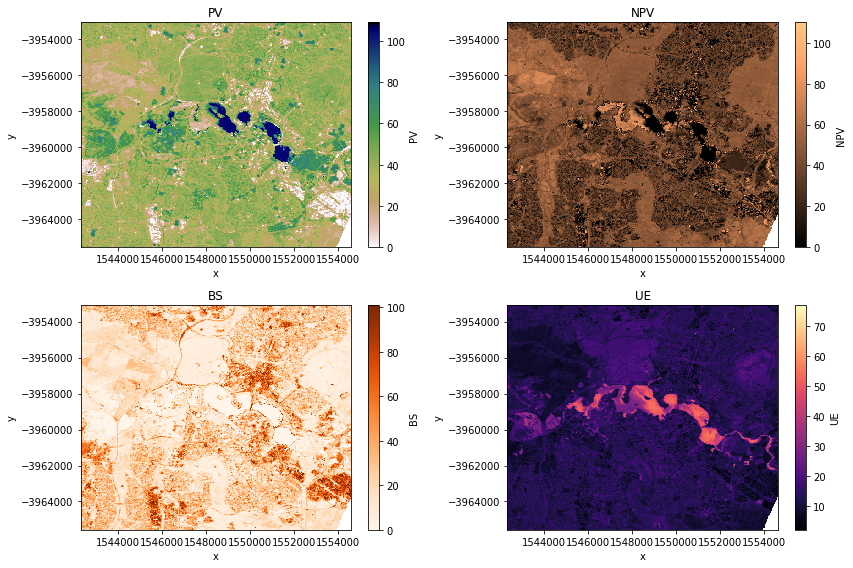

In [139]:
#set up our images on a grid using gridspec
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
ds.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
ds.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
ds.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### We could filter using the unmixing error, but using WOfS is more robust.

Text(0.5,1,'UE filtered')

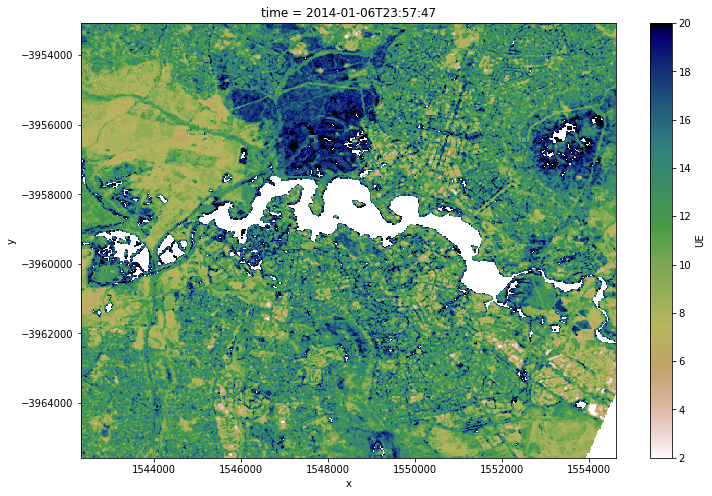

In [140]:
#this image shows that you can filter using unmixing error if you wish
plt.figure(figsize=(12,8))
ds.UE.where(ds.UE<=20.0).isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('UE filtered')

## Filter fractional cover scenes using WOfS feature layers (WOFLs) 
- Use the wofs dataset to create scene-by-scene masks to remove areas of water
- For more information on WOfS, see the [DEA WOfS and Water Classifier Notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Image_classification/DEA_WOfS_and_water_classifier.ipynb)
- There may be errors in the WOfS tiles until WOfS is finished 

### load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

In [163]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'wofs_albers', like=ds)

### Two ways of displaying what the values in the wofs data mean:
WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise

In [180]:
masking.describe_variable_flags(wofls, with_pandas=True)

,bits,values,description
cloud,6,"{'0': False, '1': True}",Cloudy
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},No water detected
high_slope,4,"{'0': False, '1': True}",High slope
nodata,0,{'1': True},No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",terrain shadow or low solar angle
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


In [175]:
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))

dry  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0': True}, 'description': 'No water detected'}
sea  {'bits': 2, 'values': {'0': False, '1': True}, 'description': 'Sea'}
wet  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'128': True}, 'description': 'Clear and Wet'}
cloud  {'bits': 6, 'values': {'0': False, '1': True}, 'description': 'Cloudy'}
nodata  {'bits': 0, 'values': {'1': True}, 'description': 'No data'}
high_slope  {'bits': 4, 'values': {'0': False, '1': True}, 'description': 'High slope'}
cloud_shadow  {'bits': 5, 'values': {'0': False, '1': True}, 'description': 'Cloud shadow'}
noncontiguous  {'bits': 1, 'values': {'0': False, '1': True}, 'description': 'At least one EO band is missing over over/undersaturated'}
terrain_or_low_angle  {'bits': 3, 'values': {'0': False, '1': True}, 'description': 'terrain shadow or low solar angle'}


### Here is what the WOFL mask looks like on one timestep:

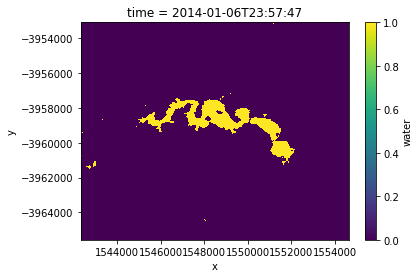

In [224]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=0).plot()
#drywofl = masking.make_mask(wofls, dry=True)
#drywofl.water.isel(time=0).plot()

In [213]:
#match WOFL times to our fractional cover times
unwofld = ds.where(ds.time == wetwofl.time)
#mask out water from fractional cover
unwofld = unwofld.where(wetwofl.water==False)

### Here is what Fractional Cover looks like with WOFL removed:

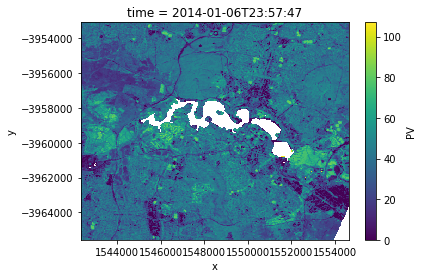

In [215]:
unwofld.PV.isel(time=0).plot()

### Edit save file path to choose where to save your output files

In [226]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save Fractional Cover scenes to NetCDF


In [227]:
try:
    DEADataHandling.write_your_netcdf(unwofld, 'FC25', savefilepath+'FC25'+'.nc', crs = ds.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

RuntimeError: Storage Unit already exists: /home/547/rjd547/FC25.nc
wrote to netCDF


## Save Fractional Cover scenes to GeoTIFF


In [228]:
ds = unwofld
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'FC25_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'FC25_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF


## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

2. TERN Auscover, 2012. *Fractional cover - Landsat, Joint Remote Sensing Research Program algorithm, Australia coverage.* Last modified by Peter Scarth on 2017/03/24 09:53. http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover